In [144]:
# Autor: Mario
# Propósito del código: Realizar un modelo de regresion logistica
# Descripción y uso: Primero se realiza la lectura de los datos. Luego se seleccionan las variables más influyentes en el modelo,
#    eliminando aquellas innecesarias para evitar redundancias y correlaciones. Posteriormente, se aplican las transformaciones necesarias a los datos.
#    Finalmente se lleva a cabo un ajuste de hiperparámetros para optimizar el modelo, el cual es evaluado para medir su desempeño.
# Estado actual: Review(Preguntar si merece la pena reducir el numero de variables a cambio de reducir ligeramente el scoring)

## Indice
* [Carga de datos](#Lectura-de-ficheros)
* [Selección y transformación de variables](#Seleccion-y-transformacion-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparametros)
* [Predicción y evaluación del modelo](#evaluacion-del-modelo)

Importo librerias necesarias

In [145]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss,confusion_matrix,make_scorer,f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

### Lectura de ficheros

En esta celda se cargan los conjuntos de datos de entrenamiento y prueba, que están almacenados en formato Parquet. Para ello, se utilizan las rutas relativas para acceder a los archivos en el sistema de archivos. Se muestra el tamaño de ambos conjuntos.

In [146]:
rutaTrain = os.path.join(os.getcwd(), "..", "..","..", "data", "P1", "train.parquet")
rutaTest = os.path.join(os.getcwd(), "..", "..","..", "data", "P1", "test.parquet")
train = pd.read_parquet(rutaTrain)
test = pd.read_parquet(rutaTest)
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (5490, 84)
Test: (2354, 84)


Se eliminan las columnas irrelevantes para el análisis, como las relacionadas con la fecha, categoría, métodos de pelea y otros atributos específicos de los peleadores, como los nombres de los peleadores, el título de la pelea o el género.

In [147]:
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])

Se divide el conjunto de datos en **variables predictoras (X)** y **variable objetivo (y)**.

In [148]:
train_x=train.drop(columns='WINNER')
train_y=train['WINNER']
test_x=test.drop(columns='WINNER')
test_y=test['WINNER']

### Seleccion y transformacion de variables

#### Tratamiento de correlaciones

En esta celda se genera un **mapa de calor (heatmap)** para visualizar la correlación entre las variables predictoras del conjunto de entrenamiento.  

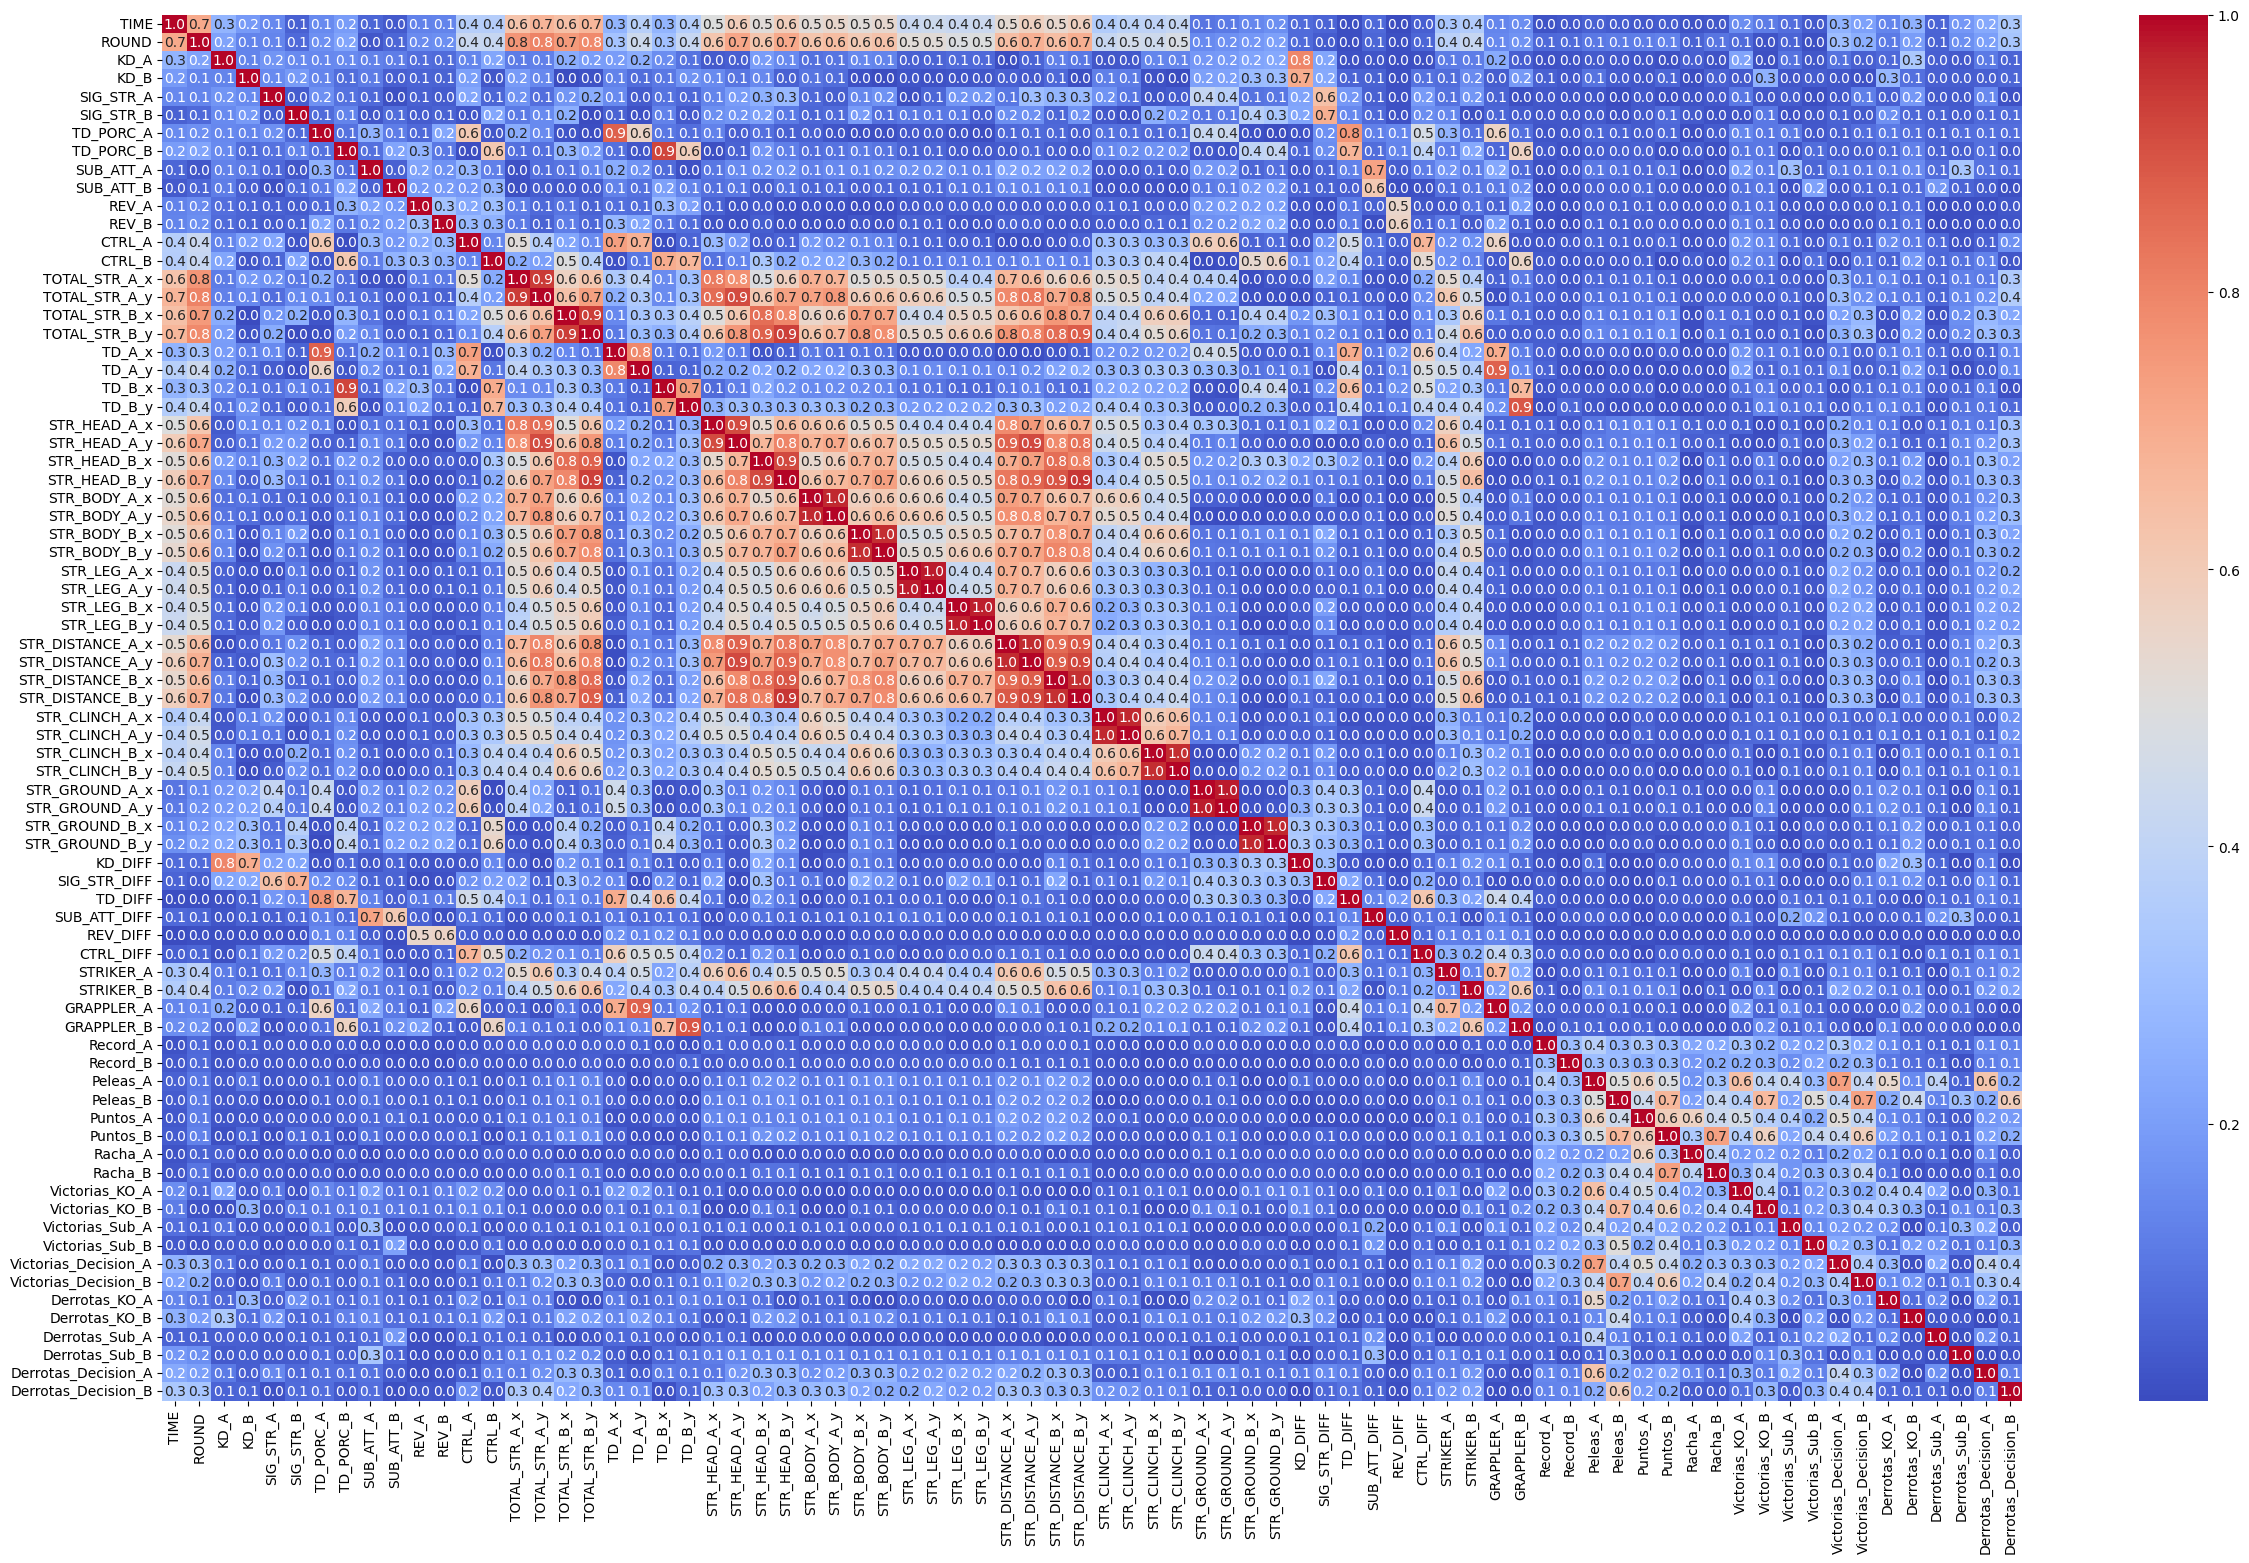

In [149]:
plt.figure(figsize=(30, 18))
sns.heatmap(train_x.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

Dado que las variables no siguen una distribución normal, se utiliza el **coeficiente de correlación de Spearman** en lugar de Pearson.  
Spearman mide la **relación monótona** entre dos variables, siendo más adecuado para datos no lineales.

In [150]:
#1. Se calcula la **matriz de correlación** usando el método de Spearman. 
correlation_matrix = train_x.corr(method='spearman')

#2. Se establece un **umbral** de 0.80 para identificar correlaciones altas.
umbral = 0.8

#3. Se extraen los pares de variables con **alta correlación** (excluyendo la diagonal).
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]

#4. Se muestran las variables cuya correlación absoluta supera el umbral.
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

print("Variables altamente correlacionadas:\n", highly_correlated)


Variables altamente correlacionadas:
             Variable 1        Variable 2  Correlación
88               ROUND     TOTAL_STR_A_y     0.802468
446          TD_PORC_A            TD_A_x     0.874402
516          TD_PORC_B            TD_B_x     0.922550
959      TOTAL_STR_A_x     TOTAL_STR_A_y     0.937687
966      TOTAL_STR_A_x      STR_HEAD_A_x     0.820151
1026     TOTAL_STR_A_y      STR_HEAD_A_x     0.850698
1027     TOTAL_STR_A_y      STR_HEAD_A_y     0.912430
1039     TOTAL_STR_A_y  STR_DISTANCE_A_y     0.824552
1080     TOTAL_STR_B_x     TOTAL_STR_B_y     0.934115
1087     TOTAL_STR_B_x      STR_HEAD_B_x     0.844549
1145     TOTAL_STR_B_y      STR_HEAD_B_x     0.873005
1146     TOTAL_STR_B_y      STR_HEAD_B_y     0.931890
1156     TOTAL_STR_B_y  STR_DISTANCE_A_y     0.802379
1157     TOTAL_STR_B_y  STR_DISTANCE_B_x     0.849392
1158     TOTAL_STR_B_y  STR_DISTANCE_B_y     0.882628
1288            TD_A_y        GRAPPLER_A     0.872579
1398            TD_B_y        GRAPPLER_B    

Se observa alta correlacion entre las variables que tienen el numero de golpes tirados(X) y el numero de golpes conectados(Y).
Elimino una de las dos evitando asi la correlacion entre variables del modelo.

In [151]:
correlacionadas=['TOTAL_STR_A_y','KD_A','TD_A_x','TD_B_x','STR_HEAD_A_x' ,'TOTAL_STR_B_y','STR_HEAD_A_y','STR_HEAD_B_y','STR_LEG_A_x',
                 'STR_LEG_B_x','STR_DISTANCE_A_y','STR_DISTANCE_B_y','STR_HEAD_B_x','GRAPPLER_A','GRAPPLER_B','STR_BODY_A_x','STR_BODY_B_x',
                 'STR_DISTANCE_B_x','STR_CLINCH_A_x','STR_CLINCH_B_x','STR_GROUND_A_x','STR_GROUND_B_x']

Para evitar problemas de **multicolinealidad**, se eliminan las variables que presentan una correlación alta (> 0.80).  
Esto ayuda a mejorar la estabilidad del modelo y reducir la redundancia en los datos.  


In [152]:
train_x=train_x.drop(columns=correlacionadas)
test_x=test_x.drop(columns=correlacionadas)

Una vez que se han eliminado las variables altamente correlacionadas, se vuelve a generar un **mapa de calor** para visualizar las nuevas correlaciones entre las variables restantes.

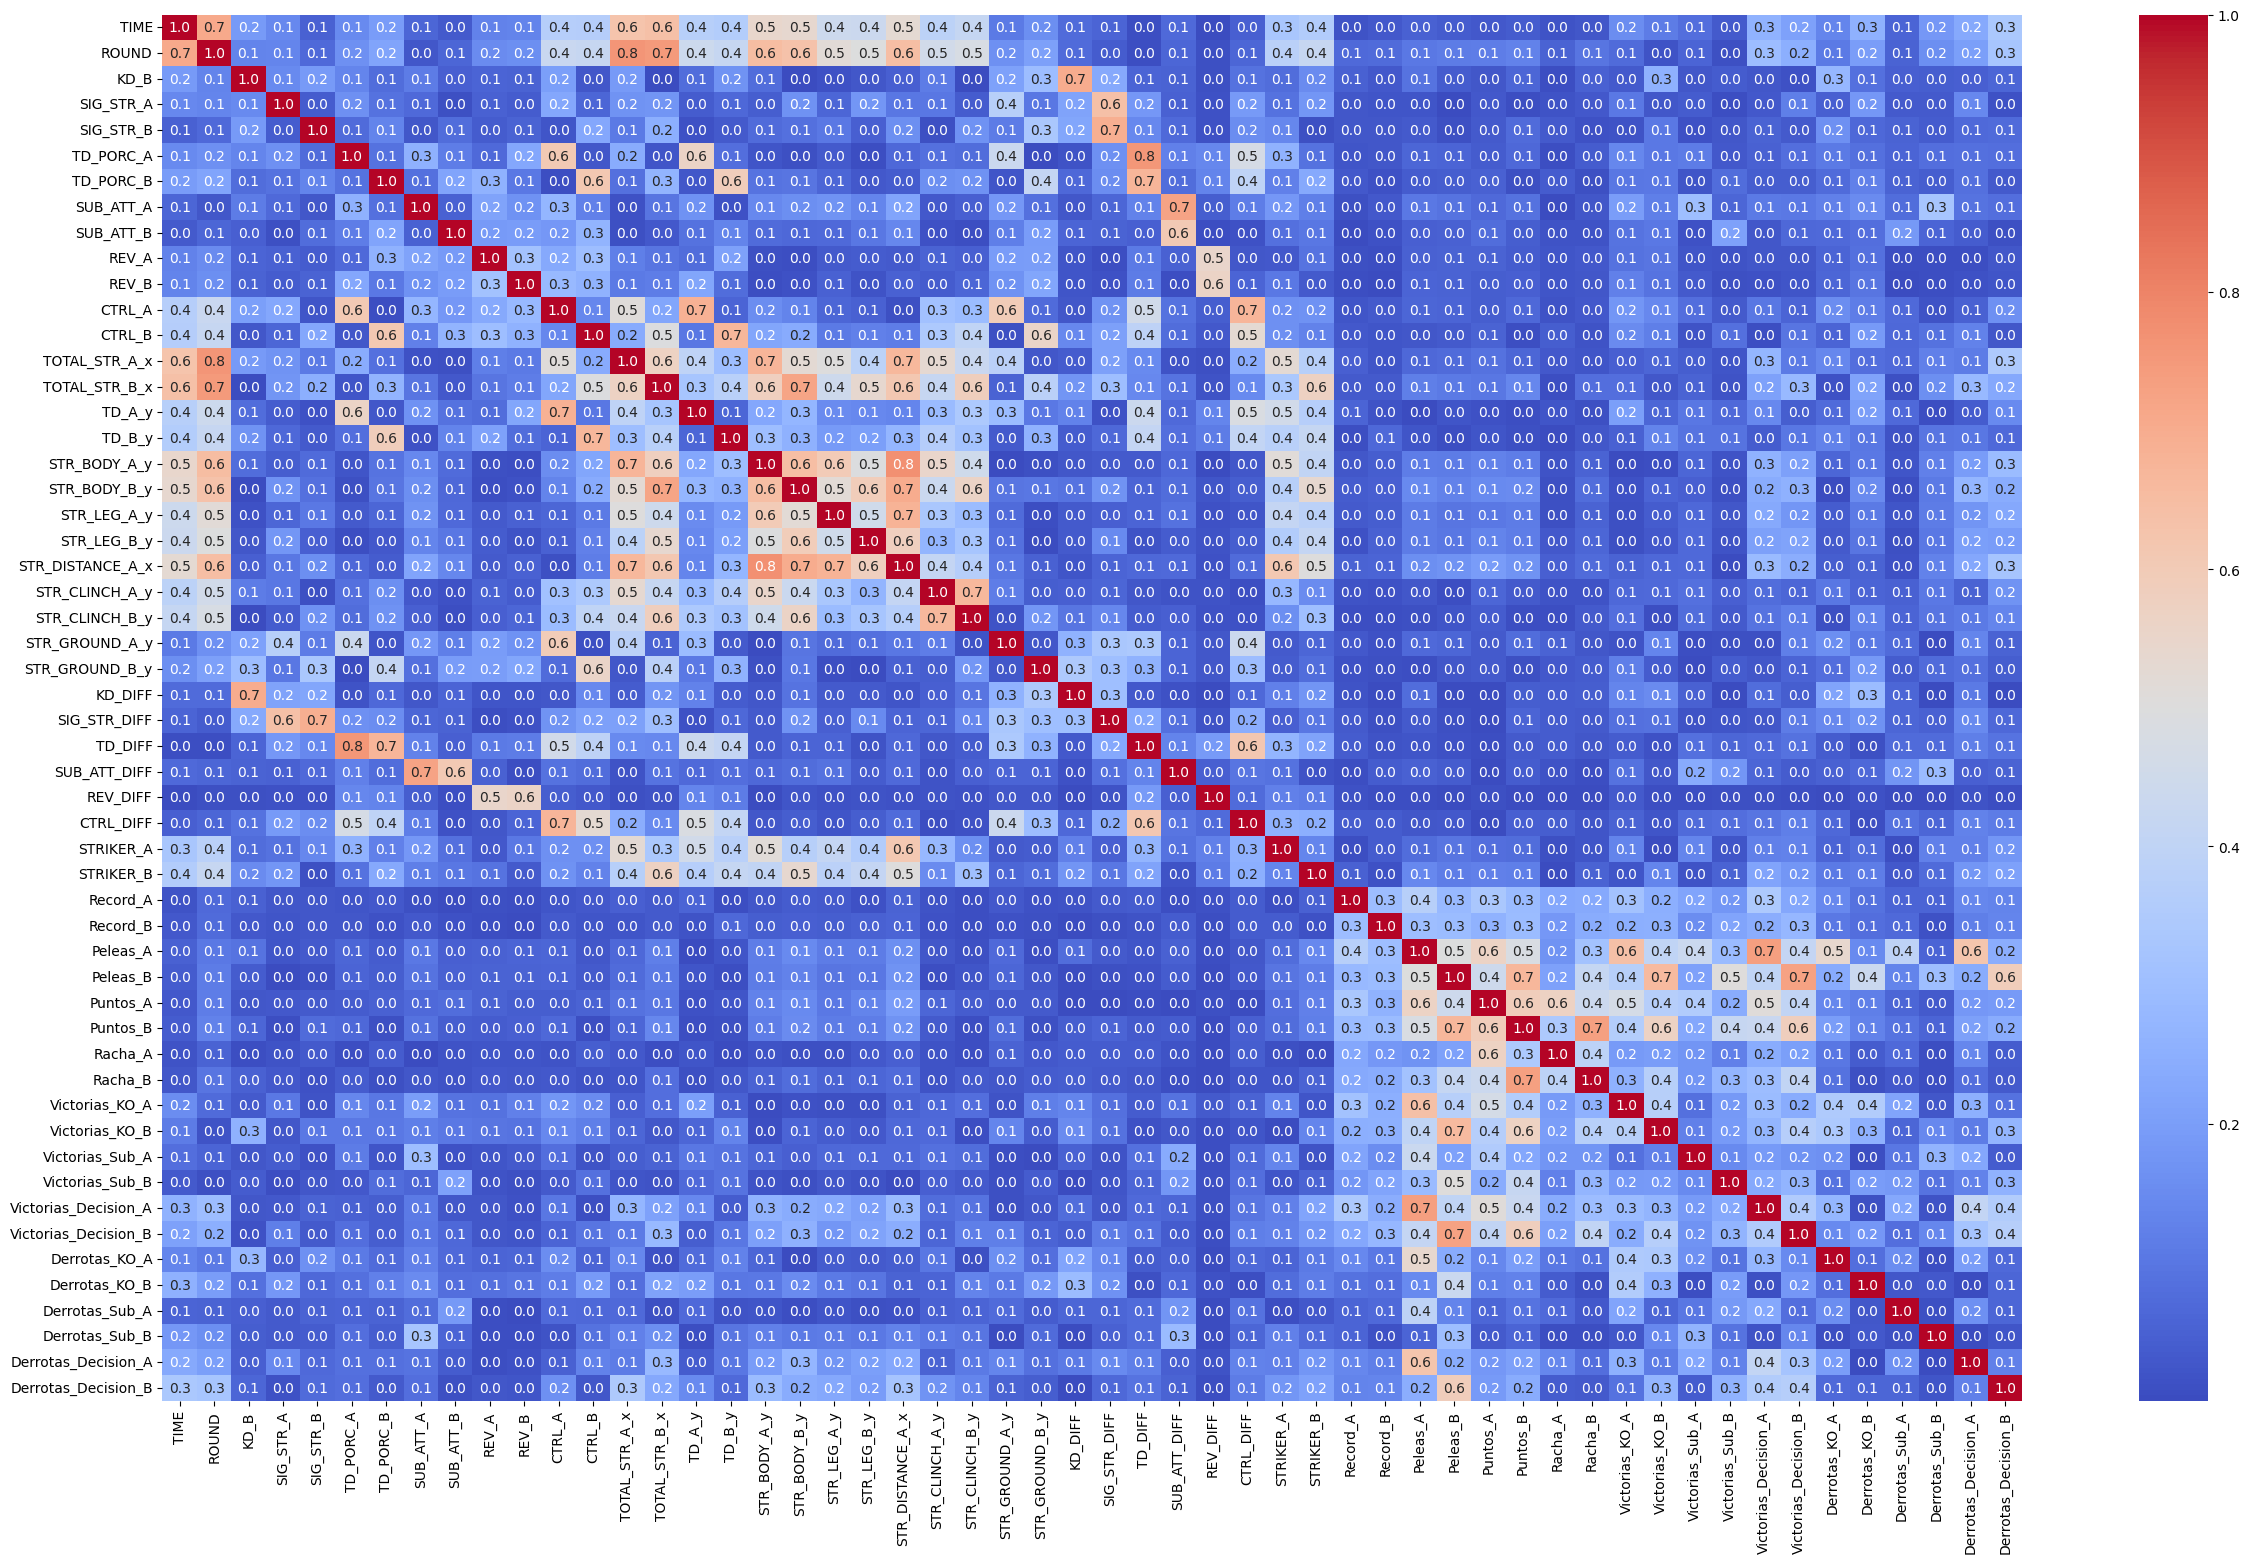

In [153]:
#Despues de eliminar correlaciones
plt.figure(figsize=(30, 18))
sns.heatmap(train_x.corr(method="spearman").abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

Se observa como ya no hay variables altamente correlacionadas entre si

#### Transformacion de variables

Muestro un resumen estadístico de las variables para ver si es necesario realizar alguna transformación.

In [154]:
#Variables antes de la transformacion
train_x.describe()

,TIME,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,REV_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.00000,5490.000000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,227.611658,0.185428,0.474093,0.435866,0.298880,0.231933,0.438069,0.333698,0.13898,0.136066,...,0.976321,0.650273,2.124044,1.448816,0.781056,0.702732,0.502732,0.455191,1.334608,1.153916
std,92.425131,0.458366,0.160498,0.170229,0.364121,0.336566,0.878214,0.777093,0.44418,0.426264,...,1.552795,1.251017,2.281298,1.895720,1.149337,0.995971,0.924993,0.794575,1.629251,1.448386
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,0.000000,0.370000,0.330000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,293.000000,0.000000,0.470000,0.430000,0.050000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,300.000000,0.000000,0.570000,0.530000,0.500000,0.420000,1.000000,0.000000,0.00000,0.000000,...,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,720.000000,4.000000,1.000000,1.000000,1.000000,1.000000,10.000000,7.000000,6.00000,4.000000,...,16.000000,14.000000,14.000000,13.000000,8.000000,8.000000,8.000000,6.000000,12.000000,12.000000


Para facilitar la convergencia del modelo, reducir los riesgos de sesgo y posteriormente poder comparar los coeficientes vamos a realizar un escalado robusto (`RobustScaler`). Elegimos este tipo de escalado porque los datos no siguen distribuciones normales y tienen mucha presencia de datos atípicos. 

Se utiliza el método `fit_transform()` en los datos de entrenamiento para ajustar y transformar los datos de prueba, y el método `transform()` en los datos de test para aplicar la misma transformación que ha sido aplicada al conjunto de prueba.

Todas las columnas son númericas por ello aplico dicha transformación a todas.
No hay columnas categoricas que transformar.

In [155]:
columnasX=train_x.columns

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

Después de aplicar la normalización con **RobustScaler** se convierten los datos transformados en **DataFrames de Pandas** para poder trabajar con ellos de manera más cómoda.
Finalmente se genera un resumen estadístico de las variables transformadas para ver como ha afectado la transformacion a la variables.

In [156]:
train_x = pd.DataFrame(train_x,columns=columnasX)
test_x = pd.DataFrame(test_x,columns=columnasX)

#Variables despues de la transformacion
train_x.describe()

,TIME,ROUND,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.00000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,-0.447865,-0.310109,0.185428,0.020464,0.029329,0.497760,0.552220,0.438069,0.333698,0.13898,...,0.976321,0.650273,0.374681,0.224408,0.781056,0.702732,0.502732,0.455191,0.167304,0.076958
std,0.633049,0.503638,0.458366,0.802490,0.851143,0.728242,0.801348,0.878214,0.777093,0.44418,...,1.552795,1.251017,0.760433,0.947860,1.149337,0.995971,0.924993,0.794575,0.814625,0.724193
min,-1.972603,-1.000000,0.000000,-2.350000,-2.150000,-0.100000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
25%,-0.952055,-1.000000,0.000000,-0.500000,-0.500000,-0.100000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.047945,0.000000,0.000000,0.500000,0.500000,0.900000,1.000000,1.000000,0.000000,0.00000,...,1.000000,1.000000,0.666667,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
max,2.924658,1.000000,4.000000,2.650000,2.850000,1.900000,2.380952,10.000000,7.000000,6.00000,...,16.000000,14.000000,4.333333,6.000000,8.000000,8.000000,8.000000,6.000000,5.500000,5.500000


#### Seleccion de variables

A continuación realizo un RFECV (Recursive Feature Elimination with Cross-Validation) para seleccionar el número óptimo de variables.

In [157]:
def aplicarRFECV(X, Y):
    '''Aplica la técnica Recursive Feature Elimination con Validación Cruzada (RFECV) para seleccionar las características
    más importantes en el conjunto de datos. La técnica elimina de manera iterativa las características menos importantes
    basándose en el rendimiento del modelo.'''

    MIN_FEATURES=5
    
    #1. Se define el modelo de regresión logística.
    modelo = LogisticRegression(max_iter = 500, random_state=42)

    #2. Se establece un KFold de 5 pliegues con `StratifiedKFold`. Esto asegura que cada pliegue tenga una proporción similar de clases.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
   
   #3. Se configura RFECV.
    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring="f1_weighted",
        min_features_to_select= MIN_FEATURES,
    )
    
    #3. Se ajusta el modelo a los datos.
    rfecv.fit(X,Y)
        
    #4. Muestro grafico que muestra la relación entre el número de variables seleccionadas y el f1-score. 
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("f1-score")
    plt.xticks(range(0,len(X.columns),2))
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    #5. Retorna el objeto rfecv que contiene los detalles sobre las características seleccionadas y los resultados del proceso de selección.
    return rfecv

Se aplica la función `aplicarRFECV` a los datos de entrenamiento ya normalizados.

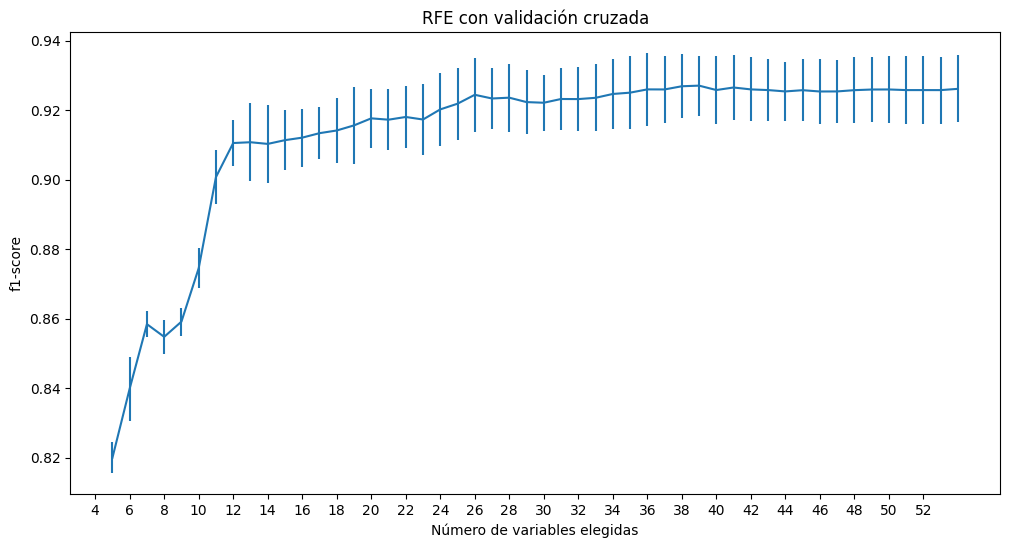

In [158]:
rfecv = aplicarRFECV(train_x, train_y)

In [159]:
rfecv.n_features_

np.int64(39)

Después de ejecutar la selección de características con **RFECV** creo un ranking para obtener variables más importantes.

In [160]:
ranking_df = pd.DataFrame({
    'Variable': train_x.columns,
    'Ranking': rfecv.ranking_
}).sort_values(by='Ranking')

En esta celda se identifican las **variables elgidas** y **descartadas** por el proceso de RFECV.  

In [161]:
num_variables=rfecv.n_features_

variablesElegidas = ranking_df.iloc[:num_variables]['Variable'].tolist()

variablesDescartadas = [v for v in train_x.columns if v not in variablesElegidas]

print('Variables descartadas: ',variablesDescartadas)
print('Variables elegidas: ',variablesElegidas)

Variables descartadas:  ['TIME', 'KD_B', 'SIG_STR_A', 'TD_PORC_A', 'SUB_ATT_B', 'REV_A', 'CTRL_B', 'TD_A_y', 'TD_B_y', 'STR_BODY_A_y', 'STR_LEG_A_y', 'STR_LEG_B_y', 'STR_CLINCH_B_y', 'STR_GROUND_B_y', 'STRIKER_B']
Variables elegidas:  ['ROUND', 'SUB_ATT_A', 'TD_PORC_B', 'SIG_STR_B', 'TOTAL_STR_A_x', 'TOTAL_STR_B_x', 'REV_B', 'CTRL_A', 'STR_GROUND_A_y', 'KD_DIFF', 'SIG_STR_DIFF', 'TD_DIFF', 'REV_DIFF', 'STR_CLINCH_A_y', 'STR_DISTANCE_A_x', 'STR_BODY_B_y', 'CTRL_DIFF', 'SUB_ATT_DIFF', 'Victorias_Sub_B', 'Victorias_Decision_A', 'Victorias_KO_B', 'Victorias_KO_A', 'Racha_B', 'Victorias_Sub_A', 'Racha_A', 'Puntos_B', 'Peleas_B', 'Puntos_A', 'Peleas_A', 'Record_B', 'Record_A', 'STRIKER_A', 'Derrotas_Decision_A', 'Derrotas_KO_B', 'Derrotas_Sub_A', 'Derrotas_Sub_B', 'Derrotas_Decision_B', 'Derrotas_KO_A', 'Victorias_Decision_B']


Se eliminan las variables a descartar asegurando que el modelo solo se entrene y se evalúe con las variables más relevantes, optimizando así su desempeño y evitando el uso de características innecesarias.

In [162]:
train_x=train_x.drop(columns=variablesDescartadas)
test_x=test_x.drop(columns=variablesDescartadas)

### Ajuste de hiperparametros

Para buscar una configuración óptima de hiperparámetros se utilizan dos estrategias, GridSearchCV y RandomizedSearchCV. 

El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

Defino la funcion `realizarGridSearch` que nos va a permitir realizar un ajuste de hiperparametros mediante una busqueda exhaustiva (probando todas las combinaciones posibles)


In [163]:
f1_scorer = make_scorer(f1_score, average='weighted')

def realizarGridSearchCV(estimador, param, kf, X, Y):
    """Implementa una estrategia de búsqueda exhaustiva de hiperparámetros utilizando GridSearchCV"""

    grid_search = GridSearchCV(estimator=estimador, param_grid=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    grid_search.fit(X, Y)
    
    return grid_search

Defino la funcion `realizarRandomizedSearchCV` que nos va a permitir realizar un ajuste de hiperparametros mediante una busqueda aleatoria.

La principal diferencia entre **RandomizedSearchCV** y **GridSearchCV** es que, en lugar de evaluar todas las combinaciones posibles de hiperparámetros, RandomizedSearchCV selecciona un subconjunto aleatorio de combinaciones. Esto lo hace más eficiente cuando el espacio de búsqueda es muy grande, aunque existe la posibilidad de no encontrar la mejor combinación.


In [164]:

def realizarRandomizedSearchCV(estimador, param, kf, X, Y):
    """Implementa una estrategia de búsqueda aleatoria de hiperparámetros utilizando RandomizedSearchCV"""

    randomized_search = RandomizedSearchCV(estimator=estimador, param_distributions=param, cv=kf,
                            scoring=f1_scorer, refit = "f1_weighted", return_train_score=True, n_jobs=-1, error_score="raise")

    randomized_search.fit(X, Y)
    
    return randomized_search


Entreno dos modelos utilizando GridSearchCV y RandomizedSearchCV para optimizar los hiperparámetros, para luego poder comparar los resultados y determinar cuál de los dos métodos ha logrado el mejor desempeño.

In [171]:
#Calculo pesos balanceados para cada clase manejando asi el desbalance entre la clase mayoritaria y minoritaria.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

#Cuadrícula de hiperparámetros para busqueda exhaustiva.
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100,1000,10000],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'class_weight': [None, class_weight_dict],
        'l1_ratio': np.linspace(0.0, 1.0, 10),
    }

#Cuadrícula de hiperparámetros para busqueda aleatoria.
param_distributions = {
    'C': uniform(0.01, 10000),      #Valores aleatorios entre 0.01 y 10000
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'class_weight': [None, class_weight_dict],
    'l1_ratio': uniform(0.0, 1.0),  #Valores aleatorios entre 0 y 1
}

#Defino modelo de regresión logistica
modelo = LogisticRegression(random_state=42, max_iter=1000)

#Aplico ajuste de hiperparámetros con GridSearchCV
grid_search = realizarGridSearchCV(modelo, param_grid, 5, train_x, train_y)

modelo_final_grid = grid_search.best_estimator_  #El mejor modelo obtenido de la búsqueda.
cv_results_grid = grid_search.cv_results_        #Los resultados de la validación cruzada.
best_params_grid = grid_search.best_params_      #Los mejores parámetros encontrados.

modelo = LogisticRegression(random_state=42, max_iter=1000)

#Aplico ajuste de hiperparámetros con RandomizedSearchCV
random_search = realizarRandomizedSearchCV(modelo, param_distributions, 5, train_x, train_y)

modelo_final_random = random_search.best_estimator_
cv_results_random = random_search.cv_results_
best_params_random = random_search.best_params_

c:\Users\Mario\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Mario\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Evaluacion del modelo

Defino la función `evaluarModelo` que realiza una evaluación del modelo utilizando varias **métricas de rendimiento** y visualiza la **matriz de confusión**.

In [166]:
def evaluarModelo(modelo,test_x,test_y):
    """Función que dado un modelo previamente ajustado y un conjunto de test evalua su rendimiento.
      Muestra las principales metricas y su matriz de confusión"""
    
    # Predicciones
    pred_y = modelo.predict(test_x)              # Predicción de clases
    prob_y = modelo.predict_proba(test_x)[:, 1]  # Probabilidad de la clase positiva

    # Cálculo de métricas
    accuracy = accuracy_score(test_y, pred_y)
    f1_val = f1_score(test_y, pred_y)
    roc_auc_val = roc_auc_score(test_y, prob_y)
    precision_val = precision_score(test_y, pred_y)
    recall_val = recall_score(test_y, pred_y)
    log_loss_val = log_loss(test_y, prob_y)

    # Imprimir métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"AUC-ROC: {roc_auc_val:.4f}")
    print(f"Precisión: {precision_val:.4f}")
    print(f"Sensibilidad (Recall): {recall_val:.4f}")
    print(f"Log-loss: {log_loss_val:.4f}")
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(test_y, pred_y)

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

Evaluo el rendimiento de un modelo sin ajuste de hiperparámetros.


-- Métricas del modelo sin hiperparámetros ajustados  --
Accuracy: 0.9316
F1-Score: 0.9053
AUC-ROC: 0.9764
Precisión: 0.9102
Sensibilidad (Recall): 0.9006
Log-loss: 0.1878


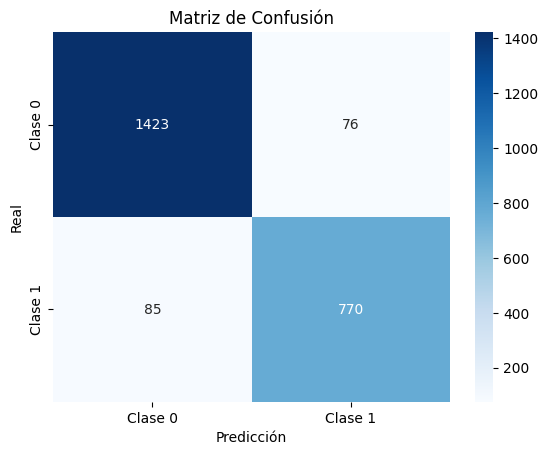

In [172]:
modelo_basico=LogisticRegression(random_state=42,max_iter=1000)
modelo_basico.fit(train_x,train_y)

print("\n-- Métricas del modelo sin hiperparámetros ajustados  --")
evaluarModelo(modelo_basico,test_x,test_y)

Se obtienen buenos resultados, vamos a ver si podemos mejorarlos gracias al ajuste de hiperparametros.

Evaluo el rendimiento del modelo ajustado con los hiperparámetros encontrados mediante **GridSearchCV**. 



-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --
Accuracy: 0.9316
F1-Score: 0.9052
AUC-ROC: 0.9761
Precisión: 0.9111
Sensibilidad (Recall): 0.8994
Log-loss: 0.1888


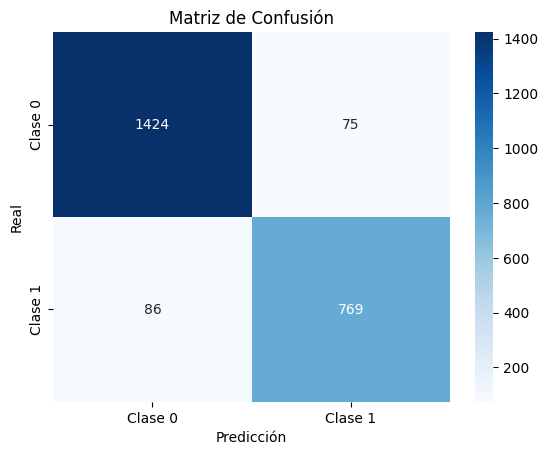

In [173]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante GridSearchCV --")
evaluarModelo(modelo_final_grid,test_x,test_y)

El modelo ajustado mediante **GriddSearchCV** muestra un rendimiento bastante bueno en todas las métricas de evaluación. El **AUC-ROC** y el **F1-Score** son bastante altos, lo que sugiere que el modelo tiene un buen equilibrio entre precisión y recall. Además, el **Log-loss** bajo sugiere que el modelo tiene una buena calificación en cuanto a probabilidades predichas. 

Evaluo el rendimiento del modelo ajustado con los hiperparámetros encontrados mediante **RandomizedSearchCV**. 



-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --
Accuracy: 0.9316
F1-Score: 0.9052
AUC-ROC: 0.9761
Precisión: 0.9111
Sensibilidad (Recall): 0.8994
Log-loss: 0.1888


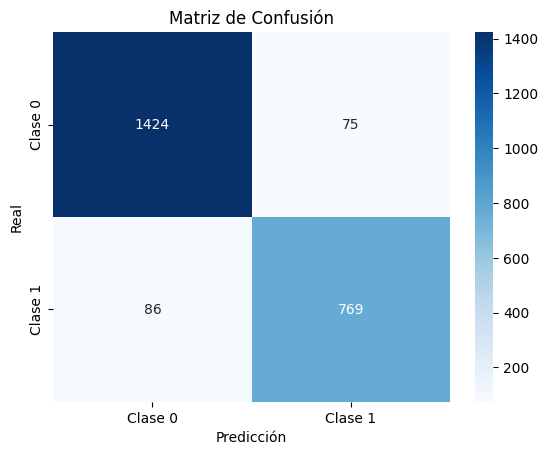

In [174]:
print("\n-- Métricas del modelo con hiperparámetros ajustados mediante RandomizedSearchCV --")
evaluarModelo(modelo_final_random,test_x,test_y)

Al igual que el modelo ajustado mediante **GridSearchCV**, el modelo ajustado mediante **RandomizedSearchCV** muestra un rendimiento impresionante en todas las métricas de evaluación.

#### Conclusión:
- Ambos métodos de búsqueda de hiperparámetros, **GridSearchCV** y **RandomizedSearchCV**, son efectivos para mejorar el rendimiento del modelo.
- En términos de desempeño, no parece haber una diferencia significativa en las métricas de evaluación entre los dos enfoques, aunque **GridSearchCV** puede ser más costoso computacionalmente al tener que probar todas las combinaciones posibles.
- **RandomizedSearchCV** parece ser una opción eficiente para obtener buenos resultados rápidamente, especialmente cuando el espacio de búsqueda es grande.